In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import inspect
import sympy
import mpmath
from sympy.utilities.lambdify import lambdify
sympy.init_printing()

### Загружаємо дані та візуалізуємо їх

In [2]:
data = pd.read_csv('v14.csv')

In [3]:
data

,Price,Demand,Supply
0,7.0,183,5
1,8.5,160,19
2,9.3,141,41
3,10.0,135,55
4,11.0,121,70
5,12.3,102,93
6,13.1,80,123
7,14.0,58,155
8,15.8,44,174
9,16.5,21,199


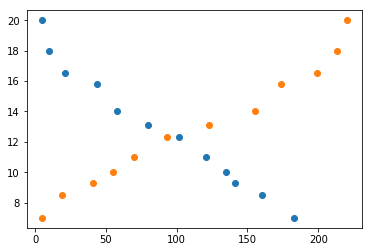

In [4]:
plt.plot(data['Demand'].values, data['Price'].values, 'o')
plt.plot(data['Supply'].values, data['Price'].values, 'o')
plt.show()

In [5]:
# Необхідні константи
p_dens = 500
min_pr, max_pr = data.iloc[0]['Price'], data.iloc[-1]['Price']
prices = np.linspace(min_pr, max_pr, p_dens)


## Знаходження аналітичного вигляду функція попиту та пропозиції
**Попит** – це ринковий вираз потреби, який є бажанням і здатністю людей купувати блага.

**Пропозиція** – це ринковий вирах потреби, що полягає в бажанні та здатності економічних агентів заявити товаридля продажу на ринку.

Ми будемо розглядати залежність попиту та пропозиції від ціни.

Функції попиту та пропозиції будемо знаходити у вигляді: 
\begin{align}
Q=\alpha f(P)+\beta
\end{align}
де $f$ задовольняє наступним властивостям.

Для функції попиту:
\begin{align}
\frac{\partial f}{\partial P} &< 0 \\
\frac{\partial^2 f}{\partial P^2} &>= 0
\end{align}
Для функції пропозиції:
\begin{align}
\frac{\partial f}{\partial P} &> 0 \\
\frac{\partial^2 f}{\partial P^2} &<= 0
\end{align}

Знайдемо значення $\alpha$ та $\beta$ за допомогою лінійної регресії з квадратичною функцією втрат.

Нехай дано вибірку $Q^*$, $P^*$. Тоді потрібно мінімізувати функціонал:
\begin{align}
L(P^*,Q^*)=(\alpha f(P^*)+\beta - Q^*)^T (\alpha f(P^*)+\beta - Q^*)
\end{align}
Тоді параметри набувають вигляду:
\begin{align}
(\alpha, \beta) &= (X^T X)^{-1} X^T Q^*\\
X &= \begin{bmatrix}f(P^*_1) & 1\\f(P^*_2) & 1\\... & ... \\ f(P^*_n) & 1\end{bmatrix} \\
\end{align}
$n$ - кількість елементів у вибірці

Модель лінійної регресії реалізована в класі sklearn.linear_model.LinearRegression.

### Вибір функції f
Функцію $f$ будемо вибирати перебором. Визначимо множини функцій $f_{d\_set}$ та $f_{s\_set}$. Виберемо по одній функції з цих множин які максимізують значення коефіцієнта детермінації.

In [6]:
# Generate X matrix from P
def generate_features(X, f):
    X = X.reshape(-1, 1)
    return np.concatenate([f(X), np.ones(X.shape)], axis=1)

# Find function that fits dataset the best
def best_f(X, y, f_set):
    curr_max = -1e9
    max_ind = 0
    for ind, f in enumerate(f_set):
        model = LinearRegression()
        generated_features = generate_features(X, f)
        model.fit(generated_features, y)
        curr_score = model.score(generated_features, y)
        if curr_score > curr_max:
            max_ind = ind
            curr_max = curr_score
    return f_set[max_ind]

In [7]:
# Model of demand/supply dependence from price as Q=a*f(P)+b
class QModel:
    # Choose function that fits dataset the best from f_set and train model
    def __init__(self, P, Q, f_set, is_demand):
        # Symbols for printing and differentiation
        self._P = sympy.symbols('P')
        self._Q = sympy.symbols('Q_' + ('d' if is_demand else 's'))
        self._E = sympy.symbols('E_' + ('d' if is_demand else 's'))
        
        self.f = best_f(P, Q, f_set)
        
        self._regression = LinearRegression(fit_intercept=False)
        self._regression.fit(generate_features(P, self.f), Q)
        
        # Demand/Supply function
        self.Q_f = lambda P: self._regression.coef_[0] * self.f(P) + self._regression.coef_[1]
        
        # Elasticity function
        self._elasticity = sympy.diff(self.Q_f(self._P), self._P) * self._P / self.Q_f(self._P)
        # lambdified elasticity function for faster usage
        self.elasticity = lambdify(self._P, self._elasticity)
        
        #Definitions for pretty output
        self._pretty_Q_f = round(self._regression.coef_[0], 2) * self.f(self._P) + round(self._regression.coef_[1], 2)
        self._pretty_elasticity = sympy.diff(self._pretty_Q_f, self._P) * self._P / self._pretty_Q_f
        
    def pretty_print(self):
        return sympy.Eq(self._Q, self._pretty_Q_f)
    
    def pretty_print_elasticity(self):
        return sympy.Eq(self._E, self._pretty_elasticity)
    
    def __call__(self, P):
        return self.Q_f(np.array(P))
        
    
    def arc_elasticity(self, P): # returns len(values) - 1 numbers
        p1, p2 = P[:-1], P[1:]
        f1, f2 = self(p1), self(p2)
        return (self(P[-1]) - self(P[0])) / (P[-1] - P[0]) * np.mean(P) / np.mean(self(P))

# Апроксимація попиту

In [8]:
f_d_set = [
    lambda x: 1 / x,
    lambda x: 1 / (x ** (1/2)),
    lambda x: 1 / (x ** (1/3)),
    lambda x: 1 / (x ** (1/4)),
    lambda x: 1 / np.log(x)
]

In [9]:
Q_d = QModel(data['Price'].values, data['Demand'].values, f_d_set, is_demand=True)

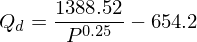

In [10]:
Q_d.pretty_print()

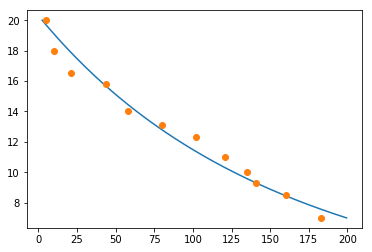

In [11]:
plt.plot(Q_d(prices), prices)
plt.plot(data['Demand'], data['Price'], 'o')
plt.show()

# Апроксимація пропозиції

In [12]:
f_s_set = [
    lambda x: x ** (1/2),
    lambda x: x ** (1/3),
    lambda x: x ** (1/4),
    lambda x: np.log(x)
]

In [13]:
Q_s = QModel(data['Price'].values, data['Supply'].values, f_s_set, is_demand=False)

In [14]:
Q_s.pretty_print()

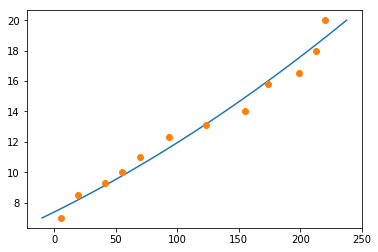

In [15]:
plt.plot(Q_s(prices), prices)
plt.plot(data['Supply'], data['Price'], 'o')
plt.show()

# Точка ринкової рівноваги

**Точка ринкової рівноваги** це значення ціни та об'єму виробництва товару, при який досягається рівність функцій попиту та пропозиції.

In [16]:
def intersection(f1, f2, values):
    ind = np.argmin(np.abs(f1(values) - f2(values)))
    return (values[ind], ((f1(values[ind:ind+1]) + f2(values[ind:ind+1])) / 2)[0])

In [17]:
balance_point = intersection(Q_d, Q_s, prices)

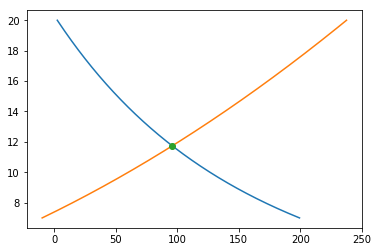

Точка ринкової рівноваги. P:12.0, Q:96.0


In [18]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(balance_point[1], balance_point[0], 'o')
plt.show()
print("Точка ринкової рівноваги. P:{}, Q:{}".format(round(balance_point[0]), round(balance_point[1])))

## Еластичність та стійкість точки рівноваги
**Точка рівноваги** називається стійкою, якщо модуль еластичності попиту в ній більший за модуль еластичності пропозиції.

 
**Еластичність** – це показник інтенсивності реакції залежної змінної від незалежної. В нашому випадку це інтенсивність залежності попиту/пропозиції від ціни. Її можна виразити як:
\begin{equation}
E_p = \frac{\frac{Q_2 - Q_1}{Q_1}}{\frac{P_2 - P_1}{P_1}} = \frac{\Delta Q}{\Delta P} \frac{P_1}{Q_1}
\end{equation}

**Точкова еластичність** вимірює інтенсивність реакції попиту/пропозиції на нескінчунно малу зміну ціни ($\Delta P \rightarrow 0$):
\begin{equation}
E_p = \frac{dQ}{dP} \frac{P}{Q}
\end{equation}

### Точкова еластичність попиту

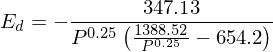

In [19]:
Q_d.pretty_print_elasticity()

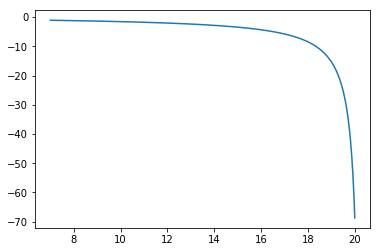

In [20]:
plt.plot(prices, Q_d.elasticity(prices))
plt.show()

In [21]:
print("Попит {}є еластичним".format("" if np.all(abs(Q_d.elasticity(prices)) > 1) else "не "))

Попит є еластичним


### Точкова еластичність пропозиції

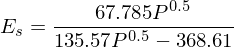

In [22]:
Q_s.pretty_print_elasticity()

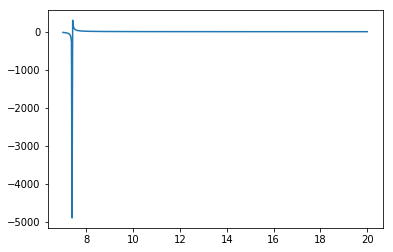

In [23]:
plt.plot(prices, Q_s.elasticity(prices))
plt.show()

In [24]:
print("Пропозиція {}є еластичною".format("" if np.all(abs(Q_s.arc_elasticity(prices)) > 1) else "не "))

Пропозиція є еластичною


### Еластичність в точці рівноваги

In [25]:
bal_elasticity = Q_d.elasticity(balance_point[0]), Q_s.elasticity(balance_point[0])

In [26]:
print("Еластичність в точці рівноваги:\nПопиту: {}\nПропозиції: {}".format(bal_elasticity[0], bal_elasticity[1]))

Еластичність в точці рівноваги:
Попиту: -1.9554043722291632
Пропозиції: 2.420903844186923


In [27]:
is_stable = np.fabs(bal_elasticity[0]) > np.fabs(bal_elasticity[1])

In [28]:
print("Точка ринкової рівноваги {}стабільна".format("" if is_stable else "не "))

Точка ринкової рівноваги не стабільна


# Дугова еластичність

**Дугова еластичність** для оцінки інтенсивності реакції використовує середнє значення величин, тобто у нашому випадку:
$$E_p = \frac{Q_n - Q_1}{P_n - P_1} \frac{\frac{\sum_{i=1}^n P_i }{n}}{\frac{\sum_{i=1}^n Q_i }{n}} = \frac{Q_n - Q_1}{P_n - P_1} \frac{\sum_{i=1}^n P_i }{\sum_{i=1}^n Q_i }$$
, де $n$ - кількість спостережень. Також вважаємо, що спостереження відсортовані по ціні.

In [29]:
def arc_elasticity(P, Q):
    return (Q[-1] - Q[0])/(P[-1] - P[0]) * np.mean(P) / np.mean(Q)

In [30]:
print("Дугова еластичність на даних вимірах попиту на відрізку [min_price, max_price]: {}".format(arc_elasticity(data['Price'].values, data['Demand'].values)))
print("Дугова еластичність отриманої моделі попиту на відрізку [min_price, max_price]: {}".format(Q_d.arc_elasticity(prices)))
print("Дугова еластичність на даних вимірах пропозиції на відрізку [min_price, max_price]: {}".format(arc_elasticity(data['Price'].values, data['Supply'].values)))
print("Дугова еластичність отриманої моделі пропозиції на відрізку [min_price, max_price]: {}".format(Q_s.arc_elasticity(prices)))

Дугова еластичність на даних вимірах попиту на відрізку [min_price, max_price]: -2.008635703918723
Дугова еластичність отриманої моделі попиту на відрізку [min_price, max_price]: -2.5637416745005495
Дугова еластичність на даних вимірах пропозиції на відрізку [min_price, max_price]: 1.8812953688593779
Дугова еластичність отриманої моделі пропозиції на відрізку [min_price, max_price]: 2.0660107007260216


# Вплив держави на ціни
### Податок та дотації на одну із сторін (споживач, виробник)
При введенні дотації чи податку на стороні споживача маємо:
$$ Q_{d\_tax}(P) = Q_d(P - tax) $$
$$ Q_{d\_dot}(P) = Q_d(P + dot) $$
При введенні дотації чи податку на стороні виробника:
$$ Q_{s\_tax}(P) = Q_s(P + tax) $$
$$ Q_{s\_dot}(P) = Q_s(P - dot) $$
Тут $tax$ та $dot$ значення податку та дотації на одиницю товару.


In [31]:
tax_dem = 5
tax_sup = 5
dot_dem = 5
dot_sup = 5

In [32]:
Q_d_tax = lambda p: Q_d(p + tax_dem)
Q_d_dot = lambda p,: Q_d(p - dot_dem)
Q_s_tax = lambda p: Q_s(p - tax_sup)
Q_s_dot = lambda p: Q_s(p + dot_sup)

In [33]:
bal_tax_dem = intersection(Q_d_tax, Q_s, prices)
bal_tax_sup = intersection(Q_d, Q_s_tax, prices)
bal_dot_dem = intersection(Q_d_dot, Q_s, prices)
bal_dot_sup = intersection(Q_d, Q_s_dot, prices)

In [34]:
bal_points1 = [bal_tax_dem, bal_dot_sup, bal_tax_sup, bal_dot_dem]

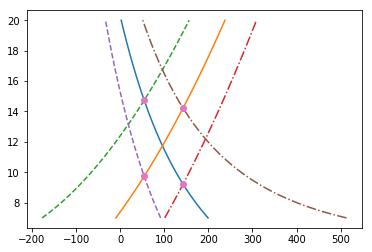

Точка ринкової рівноваги при податку зі сторони споживача 5. P:9.74, Q:54.45
Точка ринкової рівноваги при податку зі сторони виробника 5. P:14.74, Q:54.46
Точка ринкової рівноваги при дотації зі сторони споживача 5. P:14.22, Q:142.64
Точка ринкової рівноваги при дотації зі сторони виробника 5. P:9.21, Q:142.64


In [35]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_s_tax(prices), prices, '--')
plt.plot(Q_s_dot(prices), prices, '-.')
plt.plot(Q_d_tax(prices), prices, '--')
plt.plot(Q_d_dot(prices), prices, '-.')
plt.plot([p[1] for p in bal_points1], [p[0] for p in bal_points1], 'o')
plt.show()
print("Точка ринкової рівноваги при податку зі сторони споживача {}. P:{}, Q:{}".format(tax_dem, round(bal_tax_dem[0], 2), round(bal_tax_dem[1], 2)))
print("Точка ринкової рівноваги при податку зі сторони виробника {}. P:{}, Q:{}".format(tax_sup, round(bal_tax_sup[0], 2), round(bal_tax_sup[1], 2)))
print("Точка ринкової рівноваги при дотації зі сторони споживача {}. P:{}, Q:{}".format(dot_dem, round(bal_dot_dem[0], 2), round(bal_dot_dem[1], 2)))
print("Точка ринкової рівноваги при дотації зі сторони виробника {}. P:{}, Q:{}".format(dot_sup, round(bal_dot_sup[0], 2), round(bal_dot_sup[1], 2)))

### Квота з еквівалентним податком та дотацією

**Квотува́ння**  — це встановлення державними органами відповідно до чинного законодавства, міжнародного права та різних міжнародних актів, угод обмежень щодо виробництва товарів, міжрегіональних товарних або фінансових операцій.
В нашому випадку квота буде призначатися на виробництво досліджуваного товару. При квотуванні функція пропозиції набуває вигляду.
\begin{align}
Q_{s\_quote}(P) = \begin{cases} Q_s(P), & \mbox{if } Q_s(P) < quote \\ quote, & \mbox{if } Q_s(P) >= quote\end{cases}
\end{align}
Тепер введемо **еквівалентні податок** та **дотацію** для попиту та пропопзиції.

Функція пропозиції:
\begin{align}
Q_{d\_eq\_tax}(P) &= Q_d(P-eq\_tax) \\
Q_{d\_eq\_dot}(P) &= Q_d(P+eq\_dot)
\end{align}
Фукція попиту:
\begin{align}
Q_{s\_eq\_tax\_quote}(P) &= Q_{s\_quote}(P+eq\_tax) \\
Q_{s\_eq\_dot\_quote}(P) &= Q_{s\_quote}(P-eq\_dot)
\end{align}

In [36]:
eq_tax = 2.5
eq_dot = 2.5
quote = 70

In [37]:
def Q_s_quote(P):
    Q = Q_s(P)
    Q[Q > quote] = quote
    return Q

In [38]:
Q_d_eq_tax = lambda P: Q_d(P + eq_tax)
Q_d_eq_dot = lambda P: Q_d(P - eq_dot)
Q_s_eq_tax_quote = lambda P: Q_s_quote(P - eq_tax)
Q_s_eq_dot_quote = lambda P: Q_s_quote(P + eq_dot)

In [39]:
bal_eq_tax = intersection(Q_d_eq_tax, Q_s_eq_tax_quote, prices)
bal_eq_dot = intersection(Q_d_eq_dot, Q_s_eq_dot_quote, prices)

In [40]:
bal_points2 = [bal_eq_tax, bal_eq_dot]

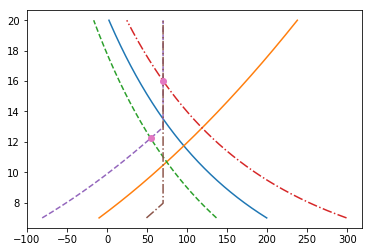

Точка ринкової рівноваги при квоті 70 та еквівалентному податку 2.5. P:12.0, Q:54.0
Точка ринкової рівноваги при квоті 70 та еквівалентній дотації 2.5. P:16.0, Q:70.0


In [41]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_d_eq_tax(prices), prices, '--')
plt.plot(Q_d_eq_dot(prices), prices, '-.')
plt.plot(Q_s_eq_tax_quote(prices), prices, '--')
plt.plot(Q_s_eq_dot_quote(prices), prices, '-.')
plt.plot([p[1] for p in bal_points2], [p[0] for p in bal_points2], 'o')
plt.show()
print("Точка ринкової рівноваги при квоті {} та еквівалентному податку {}. P:{}, Q:{}".format(quote, eq_tax, round(bal_eq_tax[0]), round(bal_eq_tax[1])))
print("Точка ринкової рівноваги при квоті {} та еквівалентній дотації {}. P:{}, Q:{}".format(quote, eq_tax, round(bal_eq_dot[0]), round(bal_eq_dot[1])))